Testing new version of alg to see if it works well on video inputs


NEW ALG

In [38]:
import cv2
import numpy as np
from collections import deque
import time
#from picamera2 import Picamera2, Preview
#from libcamera import controls
import threading
#import sendMessage
import matplotlib.pyplot as plt
import matplotlib.image as img

# Threading event
operation_active = threading.Event()
camera_lock = threading.Lock()  # Only allows one thread to access the camera

# Constants for frame center and offset
CENTER_X, CENTER_Y = 600 // 2, 500 // 2
OFFSET = 20  # Half of the side length of the 100x100 area

# Randomly selects 30 (x, y) pixels within the defined area
random_coords = [
    (np.random.randint(CENTER_X - OFFSET, CENTER_X + OFFSET),
     np.random.randint(CENTER_Y - OFFSET, CENTER_Y + OFFSET)) for _ in range(30)
]

def measure_color_change(frame, pixels):
    """
    Extract the RGB values of the specified pixels for a given frame
    and returns the average color values.
    """
    color_values = []
    for x, y in pixels:
        color_values.extend(frame[y, x])
    return np.mean(color_values)

'''def initialize_camera():
    #Initializes and configures the Picam with preview settings.
    picam2 = Picamera2()
    camera_config = picam2.create_preview_configuration()
    picam2.configure(camera_config)
    return picam2'''

def capture_frame(picam2):
    #Captures a single frame from the camera
    #frame = picam2.capture_array()
    frame = picam2
    frame_bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(frame_bw, cv2.COLOR_GRAY2RGB)

def calculate_offset(temp_array):
    #Calculatea the baseline offset value from the mean of the temporary array
    base_val = np.mean(temp_array)
    return base_val - 60  # Adjust detection sensitivity as needed

def process_frame(picam2, pixels_to_measure, temp_array, stdev_array, offset, frame_size, start_time):
    """
    Process a single frame: captures, converts, and measures the color change.
    Updates the temp_array and checks for standard deviation threshold.
    """
    #frame_rgb = capture_frame(picam2)
    frame_rgb = capture_frame(picam2)
    mean_color_value = measure_color_change(frame_rgb, pixels_to_measure)
    temp_array.append(mean_color_value)

    if len(temp_array) == temp_array.maxlen:
        if frame_size == (temp_array.maxlen - 1):
            offset = calculate_offset(temp_array)

        adjusted_mean = np.mean(temp_array) - offset
        if adjusted_mean > 80:  # Threshold for mean value
            stdev = np.std(np.array(temp_array) - offset)
            stdev_array.append(stdev)

            if stdev < 1.5:  # Threshold for standard deviation indicating stabilization
                elapsed_time = time.time() - start_time
                print(f"Time measured through framesize: {frame_size / 30:.2f}")
                print(f"Time in seconds: {elapsed_time:.2f}")
                plt.imshow(frame_rgb)
                return False  # Stop processing as reaction is complete

    return True  # Continue processing

def running_alg():
    """Run the main algorithm to monitor color change and detect the reaction completion."""
    # Initialize camera and data structures
    #picam2 = initialize_camera()
    #picam2.start_preview(Preview.QTGL)
    #picam2.start()
    time.sleep(1)

    temp_array = deque(maxlen=500)
    stdev_array = []
    frame_size = 0
    offset = 0
    start_time = time.time()
    pixels_to_measure = random_coords
    vid = cv2.VideoCapture("data/Videos/Feb23_30_trial1_sec.mp4")

    try:
        while vid.isOpened():
            ret, frame = vid.read()
            if not ret:
                print("Video is finished, alg did not find a stopping point")

            if not process_frame(frame, pixels_to_measure, temp_array, stdev_array, offset, frame_size, start_time):
                break  # Stop processing if reaction is detected as complete
            frame_size += 1
    finally:
        #picam2.stop_preview()
        #picam2.close()
        print("DONE\n")

Time measured through framesize: 34.07
Time in seconds: 0.79
DONE



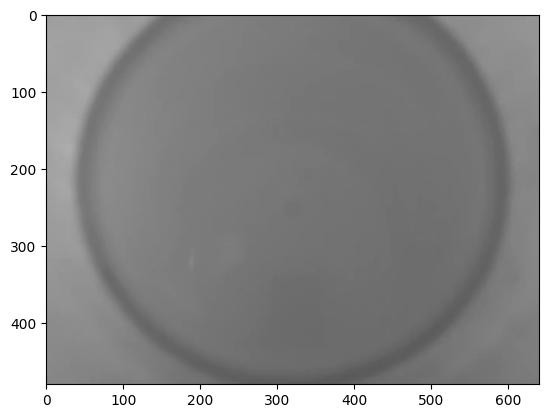

In [39]:
running_alg()

OLD ALG

In [40]:
import cv2
import numpy as np
from collections import deque
import time
#from picamera2 import Picamera2, Preview
#from libcamera import controls
import sys
import threading
import matplotlib.pyplot as plt
import matplotlib.image as img



#threading event 
operation_active = threading.Event()
#only allows one thread to effect the running_alg
camera_lock = threading.Lock()


center_x = 600 // 2  # Calculate center x-coordinate
center_y = 500 // 2  # Calculate center y-coordinate
offset = 20  # Half of the side length of the 100x100 area

#randomly selects 30 (x, y) pixels within an area definined by center_x, center_y adn offset
random_coords = [(np.random.randint(center_x - offset, center_x + offset),
                  np.random.randint(center_y - offset, center_y + offset)) for _ in range(30)]

#extracts the RGB vlues of the specified pixels for a given frame
def measure_color_change(frame, pixels):
    color_values = []
    for pixel in pixels:
        x, y = pixel
        color = frame[y, x]
        color_values.extend(color)
    return [np.mean(color_values),np.mean(color_values),np.mean(color_values)]



def running_alg2():
    #encapsulates camera so only one thread can access it
    
    #with camera_lock:
    #intializing elements
    temp_array_length = 500 
    temp_array = deque(maxlen=temp_array_length) #create a queue, data structure with first in first out operations
    t0= time.time() #record start time
    #picam2 = Picamera2() #create an instance of the Camera
    #camera_config = picam2.create_preview_configuration() #create default preview configs
    #picam2.configure(camera_config) #apply configs to camera
    #picam2.start_preview(Preview.QTGL) #opens a preview window
    #picam2.start() #start the recording
    time.sleep(1) 
    #print(temp_array)

    stdev_array=[] #list will store standard deviation values over time
    frame_size = 0 #counter for frames processed
    color_values_over_time = {'R': [], 'G': [], 'B': []} #Color values over time for each color value
    cap = cv2.VideoCapture("data/Videos/Feb23_30_trial1_sec.mp4")

    while cap.isOpened(): #while the reset button is not pressed 
        
        #frame = picam2.capture_array() #Capturues a frame
        ret, frame = cap.read()
        if not ret:
            print("Video did not finish")
            break
            
        frame_bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #convert to grayscale from BGR (openCV standard)
        frame_rgb = cv2.cvtColor(frame_bw, cv2.COLOR_GRAY2RGB) #convert from grayscale to RGB

        pixels_to_measure = random_coords #select random pixels for measurement

        color_values = measure_color_change(frame_rgb, pixels_to_measure) #returns a list of mean values
        temp_array.append(color_values[0::3]) # append mean values to temp_array
        

        if len(temp_array)==temp_array_length: #checks to see if temp_array has reached its max length 
            if(frame_size ==(temp_array_length-1)): #checks to see if it is the first time temp_Array has been filled
                base_val = np.mean(temp_array) #calculate baseline value as the mean of the temp_array: serves as a reference point
                offset = base_val-60 #subtract 60 for the value offset, to adjust detection sensitivity and discrepancies
                color_values_over_time['R'].append(np.mean(temp_array)-offset) #this is used for plotting purposes
            if(np.mean(temp_array)-offset>80): #80, check if mean exceeds threshold value (based on previous data, 80 was selected as threshold value)
                stdev_array.append(np.std(np.array(temp_array)-offset)) #calculates std of adjusted temp_array, stores the value in stdev_array
                if(np.std(np.array(temp_array))<1.5):#1.5, if std is below threshold, meaning the reaction is no longer changing color
                    t1=time.time() #measure time
                    print("Time measured through framesize: ", (frame_size/30)) #print how long it took through framesize
                    print("time in seconds: ", t1-t0) #how long it took through time lib
                    plt.imshow(frame_rgb)
                    break #stop the car 
        frame_size += 1 #increment frame size by one since frame was successfully processed
    #picam2.stop_preview() #close preview
    #picam2.close() #close camera
    

Time measured through framesize:  34.06666666666667
time in seconds:  1.812370777130127


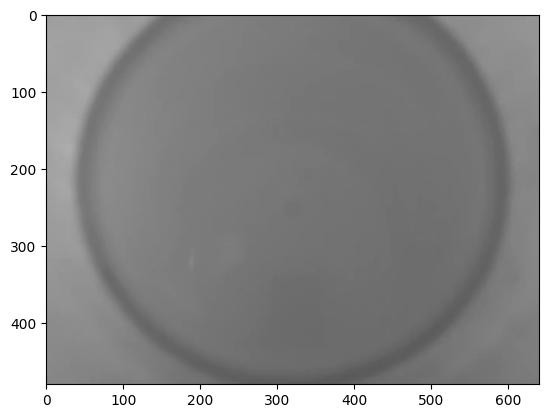

In [41]:
running_alg2()